In [1]:
# Imports

import pandas as pd

## 1. Load and Clean Data 

In the first step we need to load and clean our data

In [2]:
vax_rates = pd.read_csv('COVID-19_vaccination_rates.csv') 
vax_rates = vax_rates.loc[(vax_rates["date"]=="2021-10-25")]
vax_rates = vax_rates[["location","people_fully_vaccinated_per_hundred"]]
vax_rates.rename(columns={'location': 'Country Name'}, inplace=True)
vax_rates = vax_rates.loc[(vax_rates["people_fully_vaccinated_per_hundred"]==vax_rates["people_fully_vaccinated_per_hundred"])]
vax_rates.head()

,Country Name,people_fully_vaccinated_per_hundred
568,Africa,5.53
901,Albania,30.57
2713,Argentina,55.56
3219,Aruba,71.37
3578,Asia,41.54


In [3]:
# Create c_map
codes = pd.read_csv('country_codes.csv')

lookup_table = codes[['Alpha-3 code','Country']]

# Lookup table to dict
c_map = {}
for i, t in lookup_table.iterrows():
    key = t[0][2:5]
    val = t[1]
    
    c_map[key] = val

In [4]:
trust_in_gov = pd.read_csv('trust_in_government.csv') 
    
# enhance government trust df
trust_in_gov = trust_in_gov.assign(country=trust_in_gov['LOCATION'].map(c_map))
 
trust_in_gov = trust_in_gov.loc[(trust_in_gov["TIME"]==2019)][["country","Value"]]
trust_in_gov.rename(columns={"Value": "trust_in_government_2019"}, inplace=True)
trust_in_gov.rename(columns={"country": "Country Name"}, inplace=True)
trust_in_gov.head()

,Country Name,trust_in_government_2019
12,Australia,46.870001
26,Austria,51.233826
40,Belgium,32.790115
55,Canada,54.928097
83,Denmark,63.299903


In [5]:
gdp = pd.read_csv('gdp_per_capita.csv') 
gdp = gdp[["Country Name","2020"]]
gdp.rename(columns={'2020': 'gdp_per_capita_2020'}, inplace=True)
gdp = gdp.loc[(gdp["gdp_per_capita_2020"]==gdp["gdp_per_capita_2020"])]
gdp = gdp.set_index('Country Name')
gdp.head()

,gdp_per_capita_2020
Country Name,
Africa Eastern and Southern,3677.111255
Afghanistan,2077.874554
Africa Western and Central,4240.534782
Angola,6443.032680
Albania,13899.933981


In [6]:
secondary_edu = pd.read_csv('secondary_education.csv')  
secondary_edu = secondary_edu.loc[(secondary_edu["TIME"]==2019)].loc[(secondary_edu["SUBJECT"]=="UPPSRY")][["LOCATION","Value"]]
secondary_edu.rename(columns={"Value": "secondary_education_2019"}, inplace=True)
        
# enhance government trust df
secondary_edu = secondary_edu.assign(country=secondary_edu['LOCATION'].map(c_map))
secondary_edu = secondary_edu[['country', 'secondary_education_2019']]
secondary_edu.rename(columns={"country": "Country Name"}, inplace=True)

secondary_edu = secondary_edu.dropna()
secondary_edu.head()

,Country Name,secondary_education_2019
9,Austria,77.636
33,Belgium,77.047
50,Canada,84.317
79,Czech Republic,80.510
104,Denmark,81.629


In [7]:
tert_edu = pd.read_csv('tertiary_education.csv')[["LOCATION","SUBJECT", "TIME", "Value"]]
tert_edu = tert_edu.loc[(tert_edu["TIME"]==2019)].loc[(tert_edu["SUBJECT"]=="BACHR_MEN")|(tert_edu["SUBJECT"]=="BACHR_WOMEN")]
tert_edu.rename(columns={"Value": "tertiary_education_2019"}, inplace=True)

tert_edu = tert_edu.pivot(index="LOCATION", columns="SUBJECT", values="tertiary_education_2019")
tert_edu['tertiary_education_2019'] = tert_edu["BACHR_MEN"] + tert_edu['BACHR_WOMEN']
tert_edu = tert_edu["tertiary_education_2019"].to_frame()
tert_edu = tert_edu.reset_index() 
        
# enhance government trust df
tert_edu = tert_edu.assign(country=tert_edu['LOCATION'].map(c_map))
tert_edu.rename(columns={"country": "Country Name"}, inplace=True)

tert_edu = tert_edu[['Country Name', 'tertiary_education_2019']]
tert_edu.head()

,Country Name,tertiary_education_2019
0,Australia,69.343
1,Austria,37.418
2,Belgium,80.736
3,Switzerland,72.556
4,Chile,52.185


In [8]:
cov_data = pd.read_csv('./worldwide_covid_data.csv')
cov_deaths = cov_data.rename(columns={'Country':'location'})[['location','Deaths/1M population']]
cov_deaths.rename(columns={"location": "Country Name"}, inplace=True)

cov_deaths.head()

,Country Name,Deaths/1M population
0,Afghanistan,182
1,Albania,1034
2,Algeria,133
3,Andorra,1679
4,Angola,50


In [9]:
betterlife = pd.read_csv('./betterlifeindex_2019.csv')

health = betterlife 
health.rename(columns={"Country": "Country Name"}, inplace=True)
health = health[["LOCATION", "Country Name","Indicator", "Value"]].loc[(health["Inequality"]=="Total")]
health = health.loc[(health["Indicator"]=="Self-reported health")][["Country Name", "Value"]]
health.rename(columns={"Value": "Self-reported_health_2019"}, inplace=True)
health.head()

,Country Name,Self-reported_health_2019
1636,Australia,85.0
1637,Austria,70.0
1638,Belgium,74.0
1639,Canada,88.0
1640,Czech Republic,60.0


In [10]:
life_exp = betterlife.loc[(betterlife["Indicator"]=="Life expectancy")][["Country Name", "LOCATION", "Value"]]
life_exp.rename(columns={"Value": "Life_expectancy_2019"}, inplace=True)
#life_exp = life_exp.set_index('Country Name')
life_exp = life_exp[['Life_expectancy_2019', 'Country Name']]
life_exp.head()

,Life_expectancy_2019,Country Name
1519,82.5,Australia
1520,81.7,Austria
1521,81.5,Belgium
1522,81.9,Canada
1523,79.1,Czech Republic


In [11]:
work = betterlife.loc[(betterlife["Indicator"]=="Employees working very long hours")][["Country Name", "LOCATION", "Value"]]
work.rename(columns={"Value": "Employees_working_hours_2019"}, inplace=True)
work = work[['Country Name','Employees_working_hours_2019']]
work.head()

,Country Name,Employees_working_hours_2019
2090,Australia,13.04
2091,Austria,6.66
2092,Belgium,4.75
2093,Canada,3.69
2094,Czech Republic,5.65


In [12]:
unemp = pd.read_csv('unemployment_rate.csv') 
unemp = unemp[["Country Name","2020"]] # select and reduce
unemp.rename(columns={"2020": "unemployment_2020"}, inplace=True)
unemp = unemp.loc[(unemp["unemployment_2020"]==unemp["unemployment_2020"])]
unemp.head()

,Country Name,unemployment_2020
1,Africa Eastern and Southern,6.814177
2,Afghanistan,11.730000
3,Africa Western and Central,6.300105
4,Angola,7.700000
5,Albania,11.700000


## 2. analyse vaccination rate with each of the other factors

    In the second step we analyse the correlation and the scatter plot of each factor with the vaccination rate

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

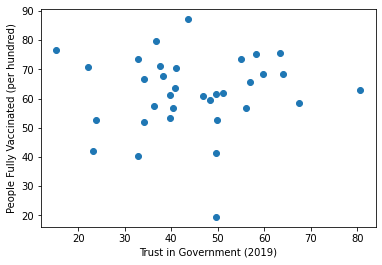

r: 0.04876726212710701


In [14]:
#### TRUST IN GOVERNMENT ######
trust_x_vax = pd.merge(trust_in_gov, vax_rates, on=["Country Name"])
trust_x_vax_r = trust_x_vax.corr().iloc[0,1]

plt.scatter(trust_x_vax['trust_in_government_2019'], trust_x_vax['people_fully_vaccinated_per_hundred'])
plt.xlabel('Trust in Government (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()
print("r: {}".format(trust_x_vax_r))

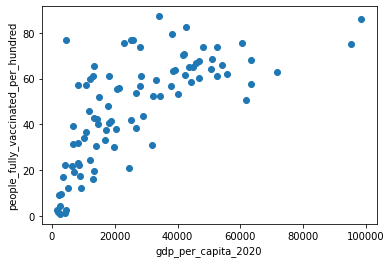

r: 0.7006793183652771


In [15]:
#### GDP ######
gdp_x_vax = pd.merge(gdp, vax_rates, on=["Country Name"])
gdp_x_vax_r = gdp_x_vax.corr().iloc[0,1]

plt.scatter(gdp_x_vax['gdp_per_capita_2020'], gdp_x_vax['people_fully_vaccinated_per_hundred'])
plt.xlabel('gdp_per_capita_2020')
plt.ylabel('people_fully_vaccinated_per_hundred')
plt.show()
print("r: {}".format(gdp_x_vax_r))

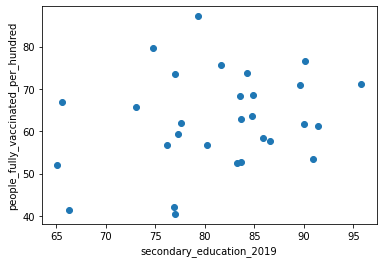

r: 0.24994288969897402


In [16]:
#### secondary education ######
edu2_x_vax = pd.merge(secondary_edu, vax_rates, on=["Country Name"])
edu2_x_vax_r = edu2_x_vax.corr().iloc[0,1]

plt.scatter(edu2_x_vax['secondary_education_2019'], edu2_x_vax['people_fully_vaccinated_per_hundred'])
plt.xlabel('secondary_education_2019')
plt.ylabel('people_fully_vaccinated_per_hundred')
plt.show()
print("r: {}".format(edu2_x_vax_r))

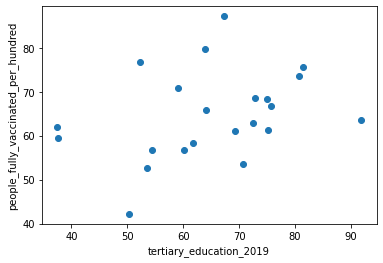

r: 0.24994288969897402


In [17]:
#### tertiary education ######
edu3_x_vax = pd.merge(tert_edu, vax_rates, on=["Country Name"])
edu3_x_vax_r = edu3_x_vax.corr().iloc[0,1]

plt.scatter(edu3_x_vax['tertiary_education_2019'], edu3_x_vax['people_fully_vaccinated_per_hundred'])
plt.xlabel('tertiary_education_2019')
plt.ylabel('people_fully_vaccinated_per_hundred')
plt.show()
print("r: {}".format(edu2_x_vax_r))

In [18]:
#### COVID deaths ######


data = pd.merge(cov_deaths, vax_rates, on=["Country Name"])
data

,Country Name,Deaths/1M population,people_fully_vaccinated_per_hundred
0,Albania,1034,30.57
1,Argentina,2539,55.56
2,Aruba,1602,71.37
3,Australia,71,61.01
4,Austria,1273,62.03
...,...,...,...
85,Turkey,847,56.70
86,Ukraine,1692,16.29
87,Uruguay,1746,75.40
88,Vietnam,230,22.23


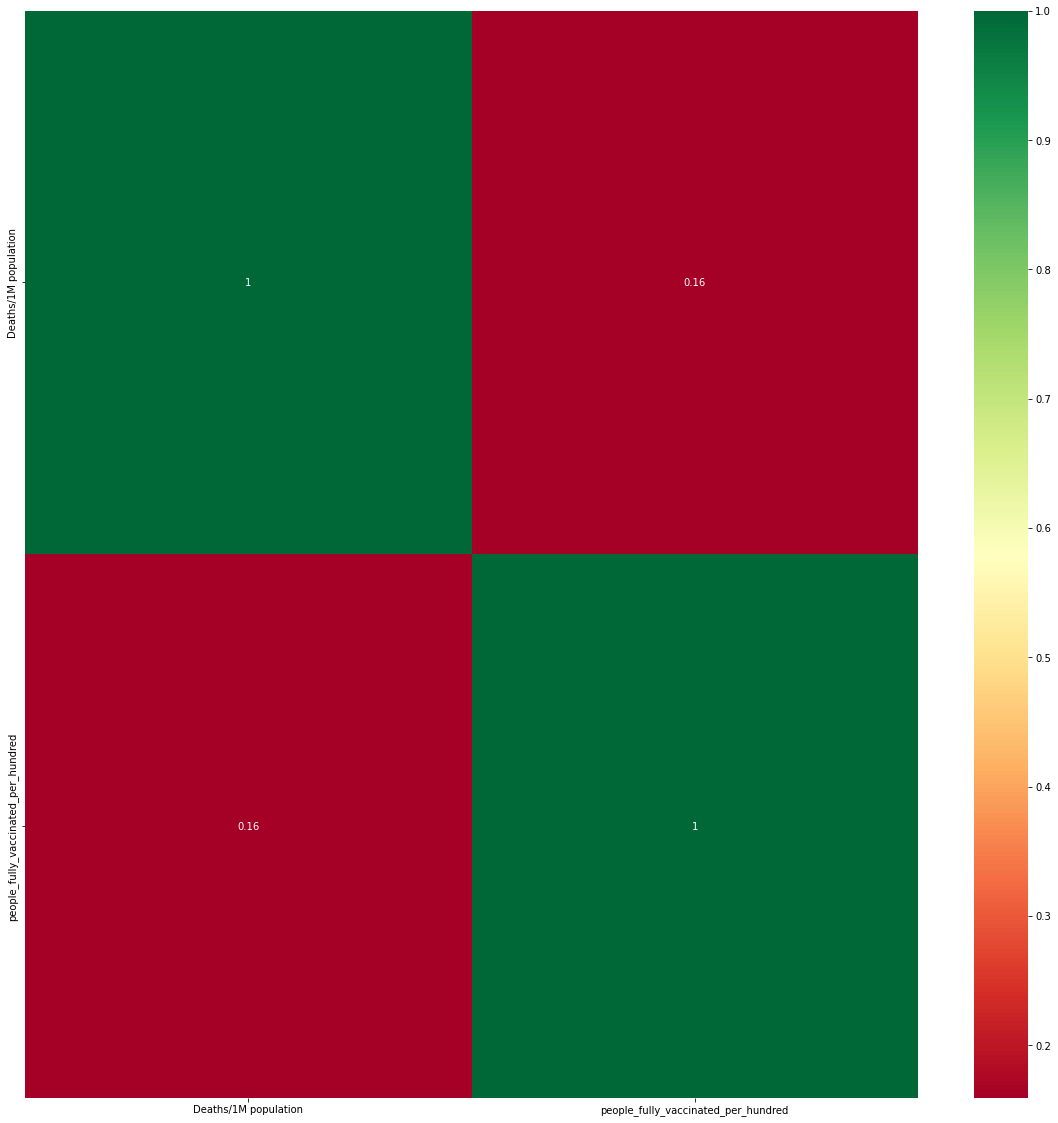

In [19]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[['Deaths/1M population', 'people_fully_vaccinated_per_hundred']].corr(),annot=True,cmap="RdYlGn")

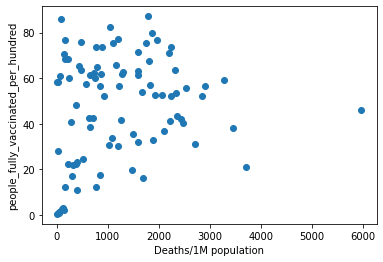

In [20]:
plt.scatter(data['Deaths/1M population'], data['people_fully_vaccinated_per_hundred'])
plt.xlabel('Deaths/1M population')
plt.ylabel('people_fully_vaccinated_per_hundred')
plt.show()

In [21]:
#### Self reported health ######


data = pd.merge(health, vax_rates, on=["Country Name"])
data

,Country Name,Self-reported_health_2019,people_fully_vaccinated_per_hundred
0,Australia,85.0,61.01
1,Austria,70.0,62.03
2,Belgium,74.0,73.63
3,Canada,88.0,73.73
4,Denmark,71.0,75.72
5,Finland,70.0,68.51
6,France,66.0,67.70
7,Germany,65.0,65.77
8,Greece,74.0,61.20
9,Hungary,60.0,59.39


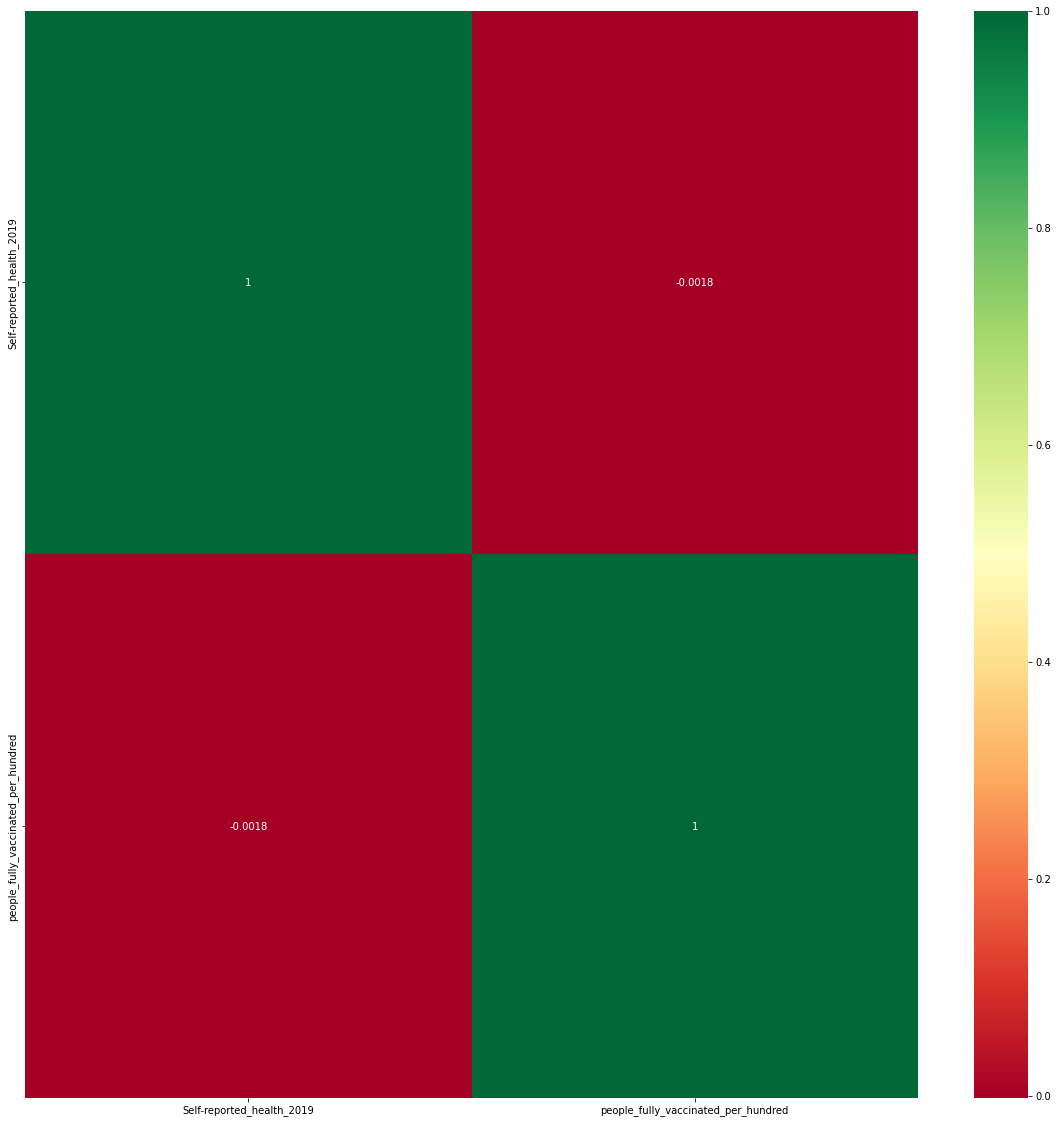

In [22]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[['Self-reported_health_2019', 'people_fully_vaccinated_per_hundred']].corr(),annot=True,cmap="RdYlGn")

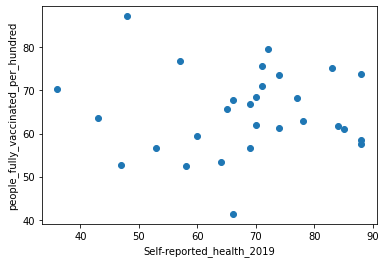

In [23]:
plt.scatter(data['Self-reported_health_2019'], data['people_fully_vaccinated_per_hundred'])
plt.xlabel('Self-reported_health_2019')
plt.ylabel('people_fully_vaccinated_per_hundred')
plt.show()

In [24]:
#### life expectancy ######


data = pd.merge(life_exp, vax_rates, on=["Country Name"])
data

,Life_expectancy_2019,Country Name,people_fully_vaccinated_per_hundred
0,82.5,Australia,61.01
1,80.4,Australia,61.01
2,84.6,Australia,61.01
3,81.7,Austria,62.03
4,79.3,Austria,62.03
...,...,...,...
91,73.1,Colombia,40.42
92,79.4,Colombia,40.42
93,74.8,Lithuania,63.67
94,69.5,Lithuania,63.67


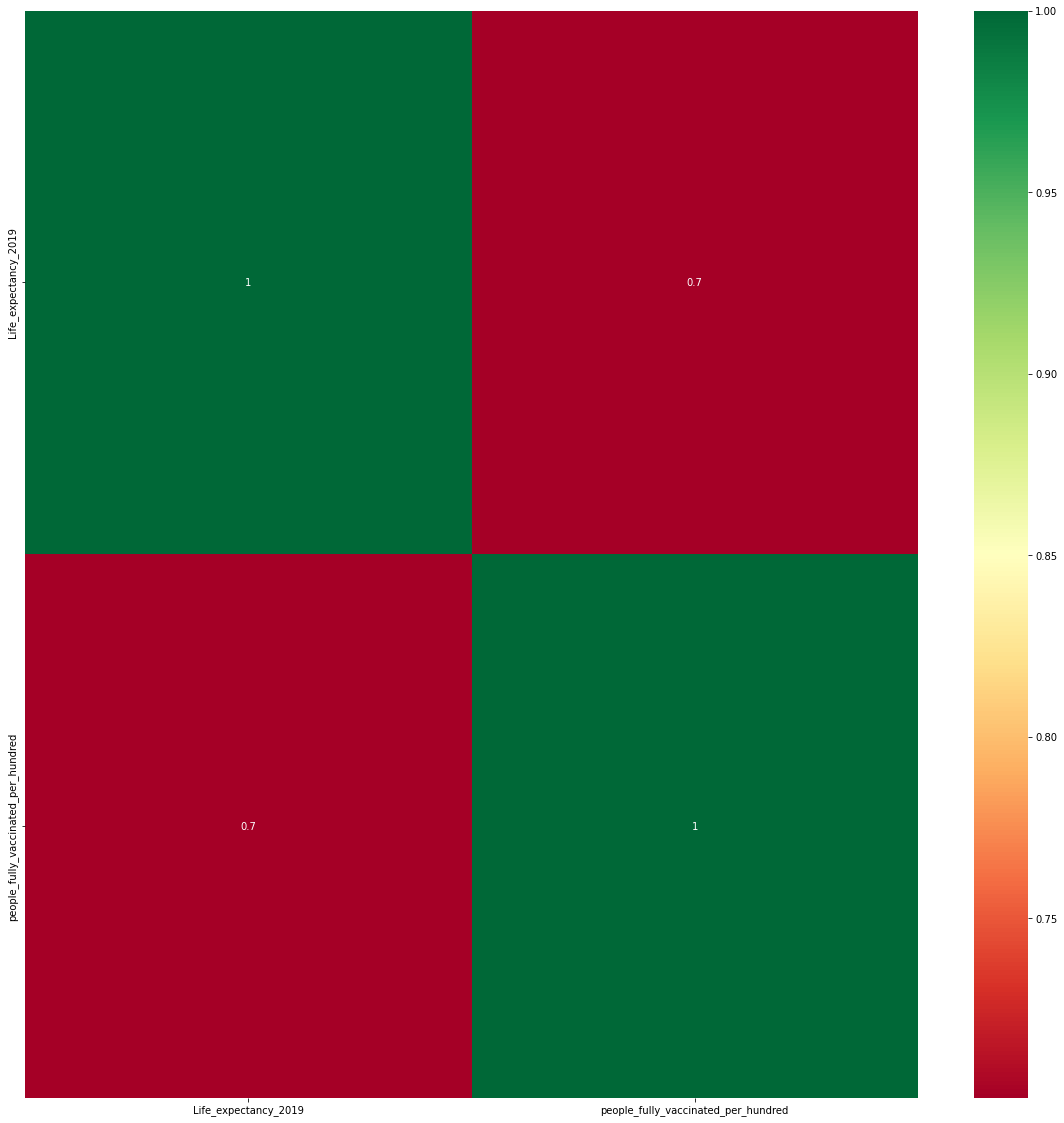

In [25]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[['Life_expectancy_2019', 'people_fully_vaccinated_per_hundred']].corr(),annot=True,cmap="RdYlGn")

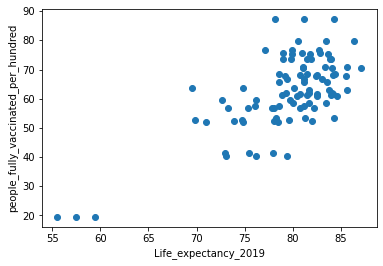

In [26]:
plt.scatter(data['Life_expectancy_2019'], data['people_fully_vaccinated_per_hundred'])
plt.xlabel('Life_expectancy_2019')
plt.ylabel('people_fully_vaccinated_per_hundred')
plt.show()

In [27]:
#### very long working hours ######

data = pd.merge(work, vax_rates, on=["Country Name"])
data

,Country Name,Employees_working_hours_2019,people_fully_vaccinated_per_hundred
0,Australia,13.04,61.01
1,Australia,19.17,61.01
2,Australia,6.31,61.01
3,Austria,6.66,62.03
4,Austria,10.01,62.03
...,...,...,...
88,Colombia,32.09,40.42
89,Colombia,19.37,40.42
90,Lithuania,0.54,63.67
91,Lithuania,0.67,63.67


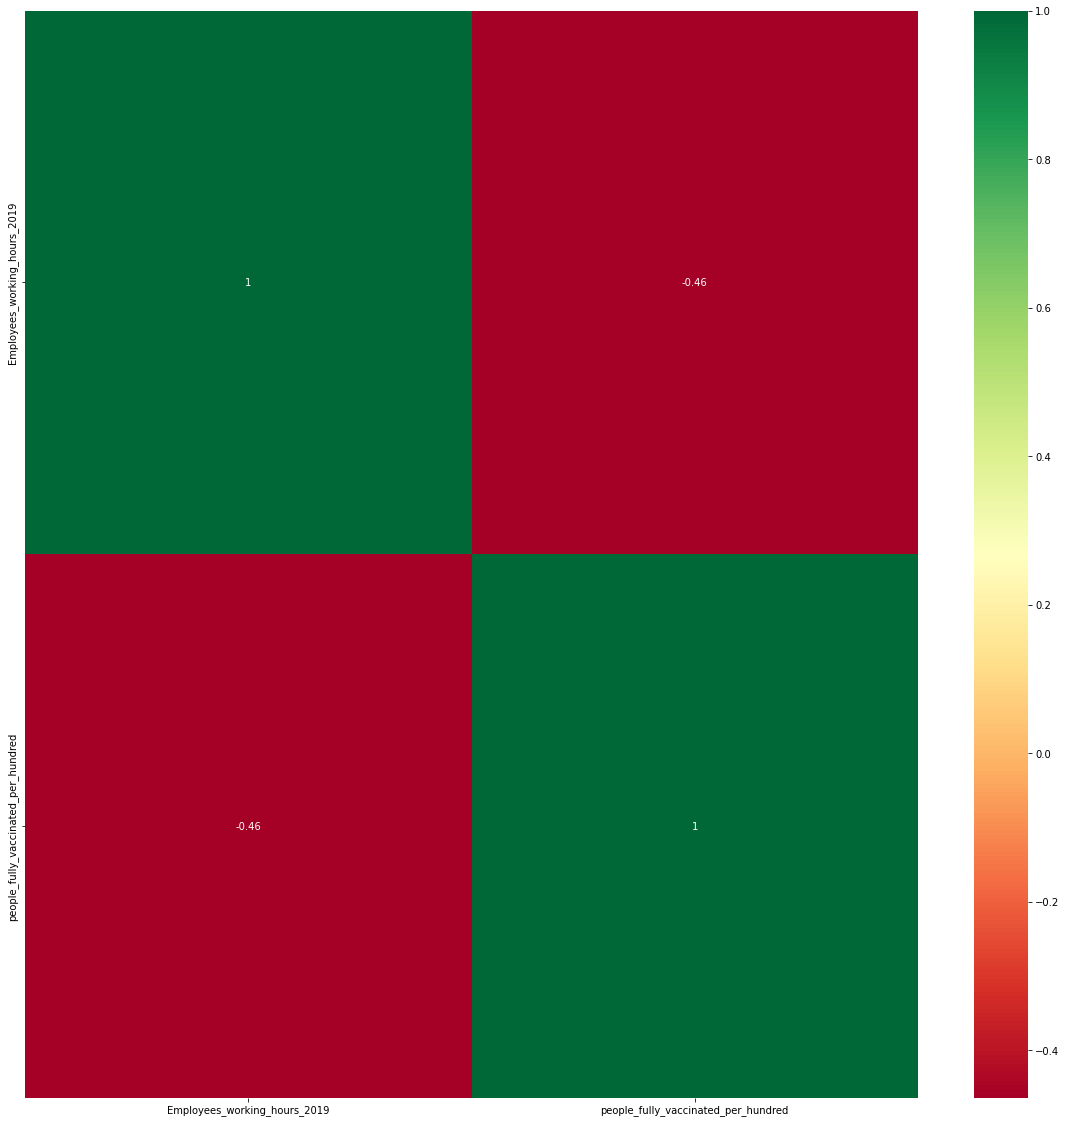

In [28]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[['Employees_working_hours_2019', 'people_fully_vaccinated_per_hundred']].corr(),annot=True,cmap="RdYlGn")

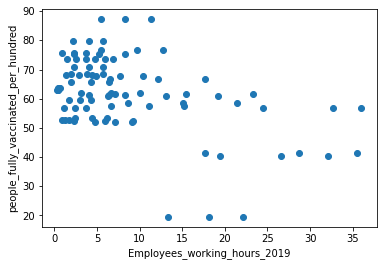

In [29]:
plt.scatter(data['Employees_working_hours_2019'], data['people_fully_vaccinated_per_hundred'])
plt.xlabel('Employees_working_hours_2019')
plt.ylabel('people_fully_vaccinated_per_hundred')
plt.show()

In [30]:
#### unemployment ######

data = pd.merge(unemp, vax_rates, on=["Country Name"])
data

,Country Name,unemployment_2020,people_fully_vaccinated_per_hundred
0,Albania,11.700000,30.57
1,Argentina,11.670000,55.56
2,Australia,6.610000,61.01
3,Austria,5.770000,62.03
4,Azerbaijan,6.270000,42.29
...,...,...,...
88,Vanuatu,1.950000,9.72
89,World,6.471281,37.62
90,Samoa,8.870000,39.27
91,South Africa,28.740000,19.48


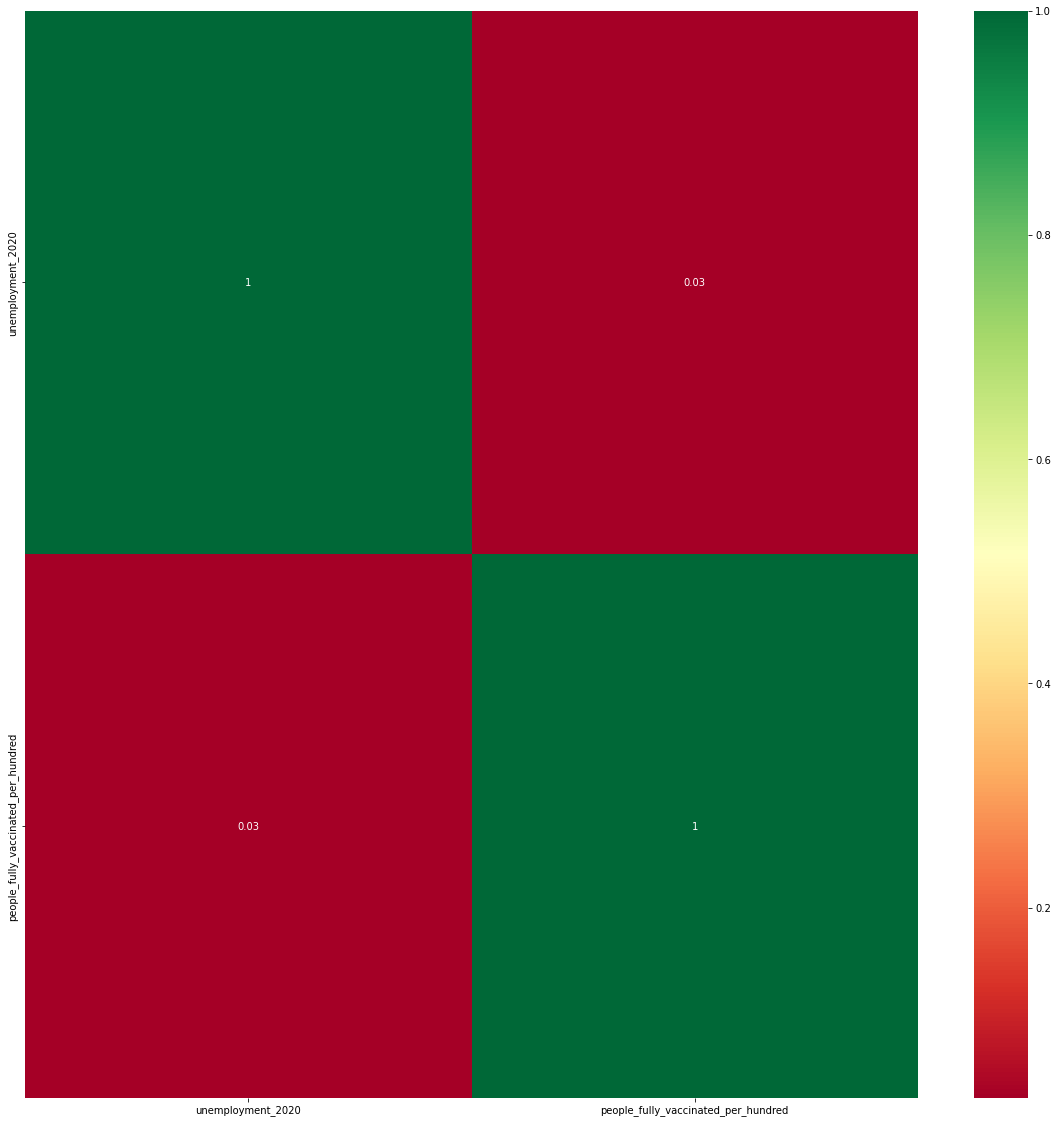

In [31]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[['unemployment_2020', 'people_fully_vaccinated_per_hundred']].corr(),annot=True,cmap="RdYlGn")

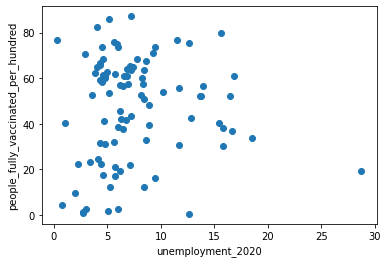

In [32]:
plt.scatter(data['unemployment_2020'], data['people_fully_vaccinated_per_hundred'])
plt.xlabel('unemployment_2020')
plt.ylabel('people_fully_vaccinated_per_hundred')
plt.show()

In [33]:
### Plot all data ######

In [34]:
data = pd.merge(vax_rates, trust_in_gov, on=["Country Name"])
data = pd.merge(data, gdp, on=["Country Name"])
data = pd.merge(data, secondary_edu, on=["Country Name"])
data = pd.merge(data, tert_edu, on=["Country Name"])
data = pd.merge(data, cov_deaths, on=["Country Name"])
data = pd.merge(data, health, on=["Country Name"])
data = pd.merge(data, life_exp, on=["Country Name"])
data = pd.merge(data, work, on=["Country Name"])
data = pd.merge(data, unemp, on=["Country Name"])
data

,Country Name,people_fully_vaccinated_per_hundred,trust_in_government_2019,gdp_per_capita_2020,secondary_education_2019,tertiary_education_2019,Deaths/1M population,Self-reported_health_2019,Life_expectancy_2019,Employees_working_hours_2019,unemployment_2020
0,Austria,62.03,51.233826,55648.874565,77.636,37.418,1273,70.0,81.7,6.66,5.77
1,Austria,62.03,51.233826,55648.874565,77.636,37.418,1273,70.0,81.7,10.01,5.77
2,Austria,62.03,51.233826,55648.874565,77.636,37.418,1273,70.0,81.7,3.10,5.77
3,Austria,62.03,51.233826,55648.874565,77.636,37.418,1273,70.0,79.3,6.66,5.77
4,Austria,62.03,51.233826,55648.874565,77.636,37.418,1273,70.0,79.3,10.01,5.77
...,...,...,...,...,...,...,...,...,...,...,...
166,Turkey,56.70,56.126091,28113.736584,76.235,60.084,847,69.0,75.3,36.01,13.92
167,Turkey,56.70,56.126091,28113.736584,76.235,60.084,847,69.0,75.3,24.48,13.92
168,Turkey,56.70,56.126091,28113.736584,76.235,60.084,847,69.0,80.7,32.64,13.92
169,Turkey,56.70,56.126091,28113.736584,76.235,60.084,847,69.0,80.7,36.01,13.92


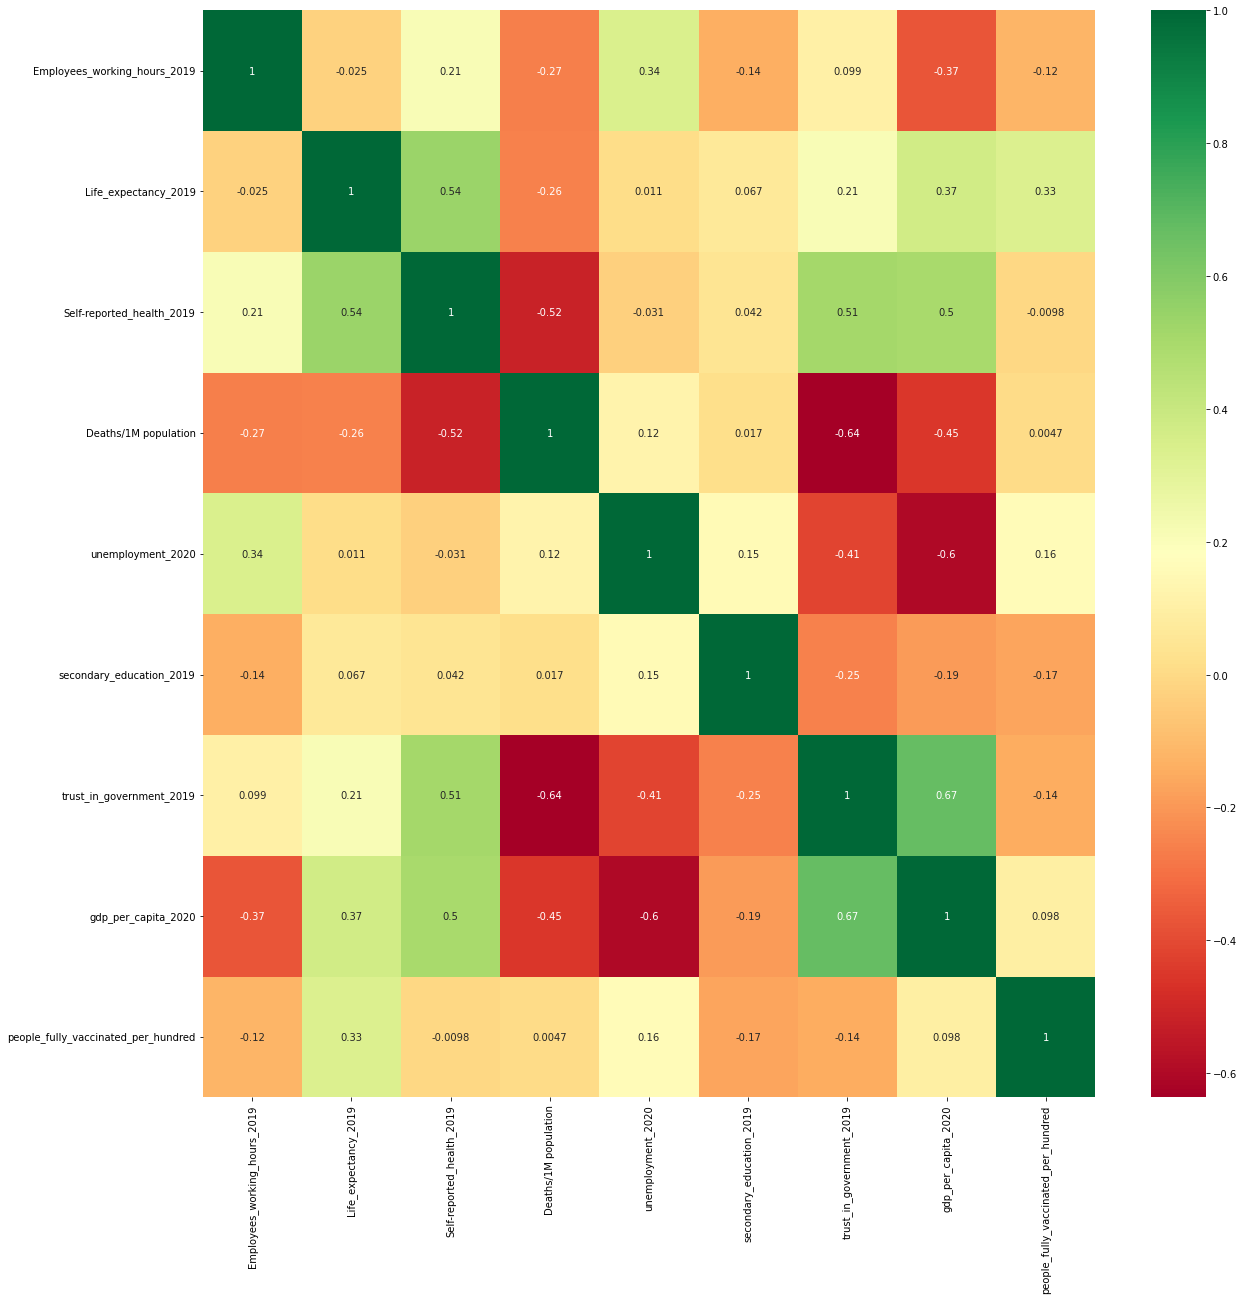

In [35]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[["Employees_working_hours_2019", "Life_expectancy_2019", "Self-reported_health_2019","Deaths/1M population", "unemployment_2020","secondary_education_2019","trust_in_government_2019", "gdp_per_capita_2020", "people_fully_vaccinated_per_hundred"]].corr(),annot=True,cmap="RdYlGn")

In [36]:
#https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot

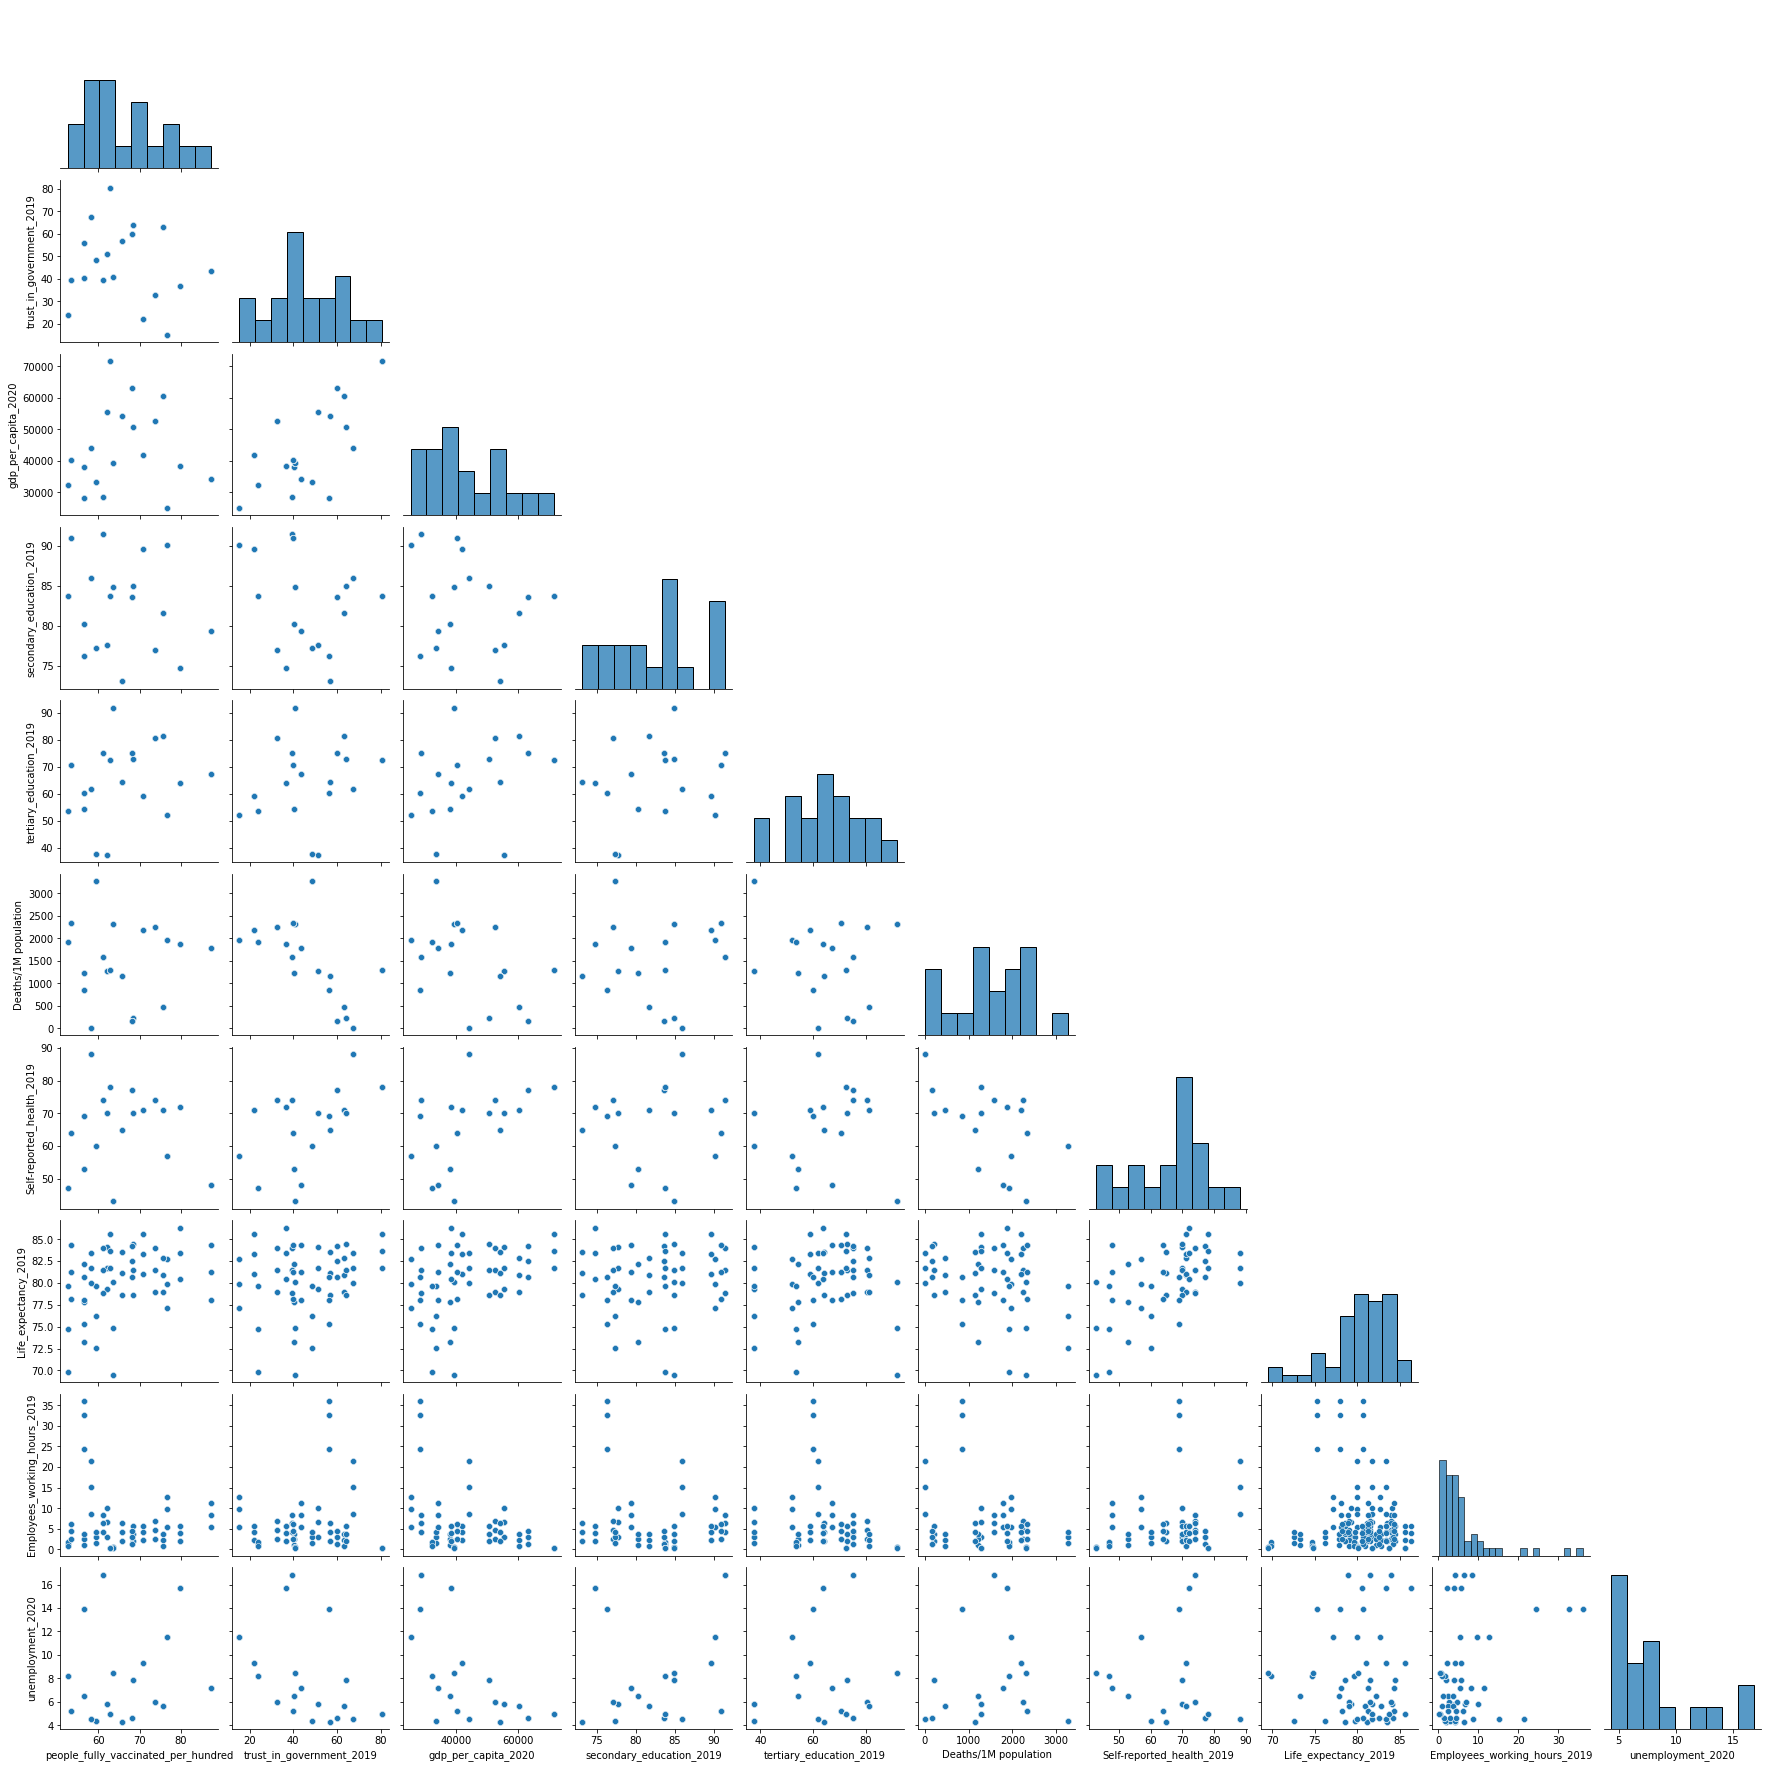

In [41]:
sns.pairplot(data, corner=True)

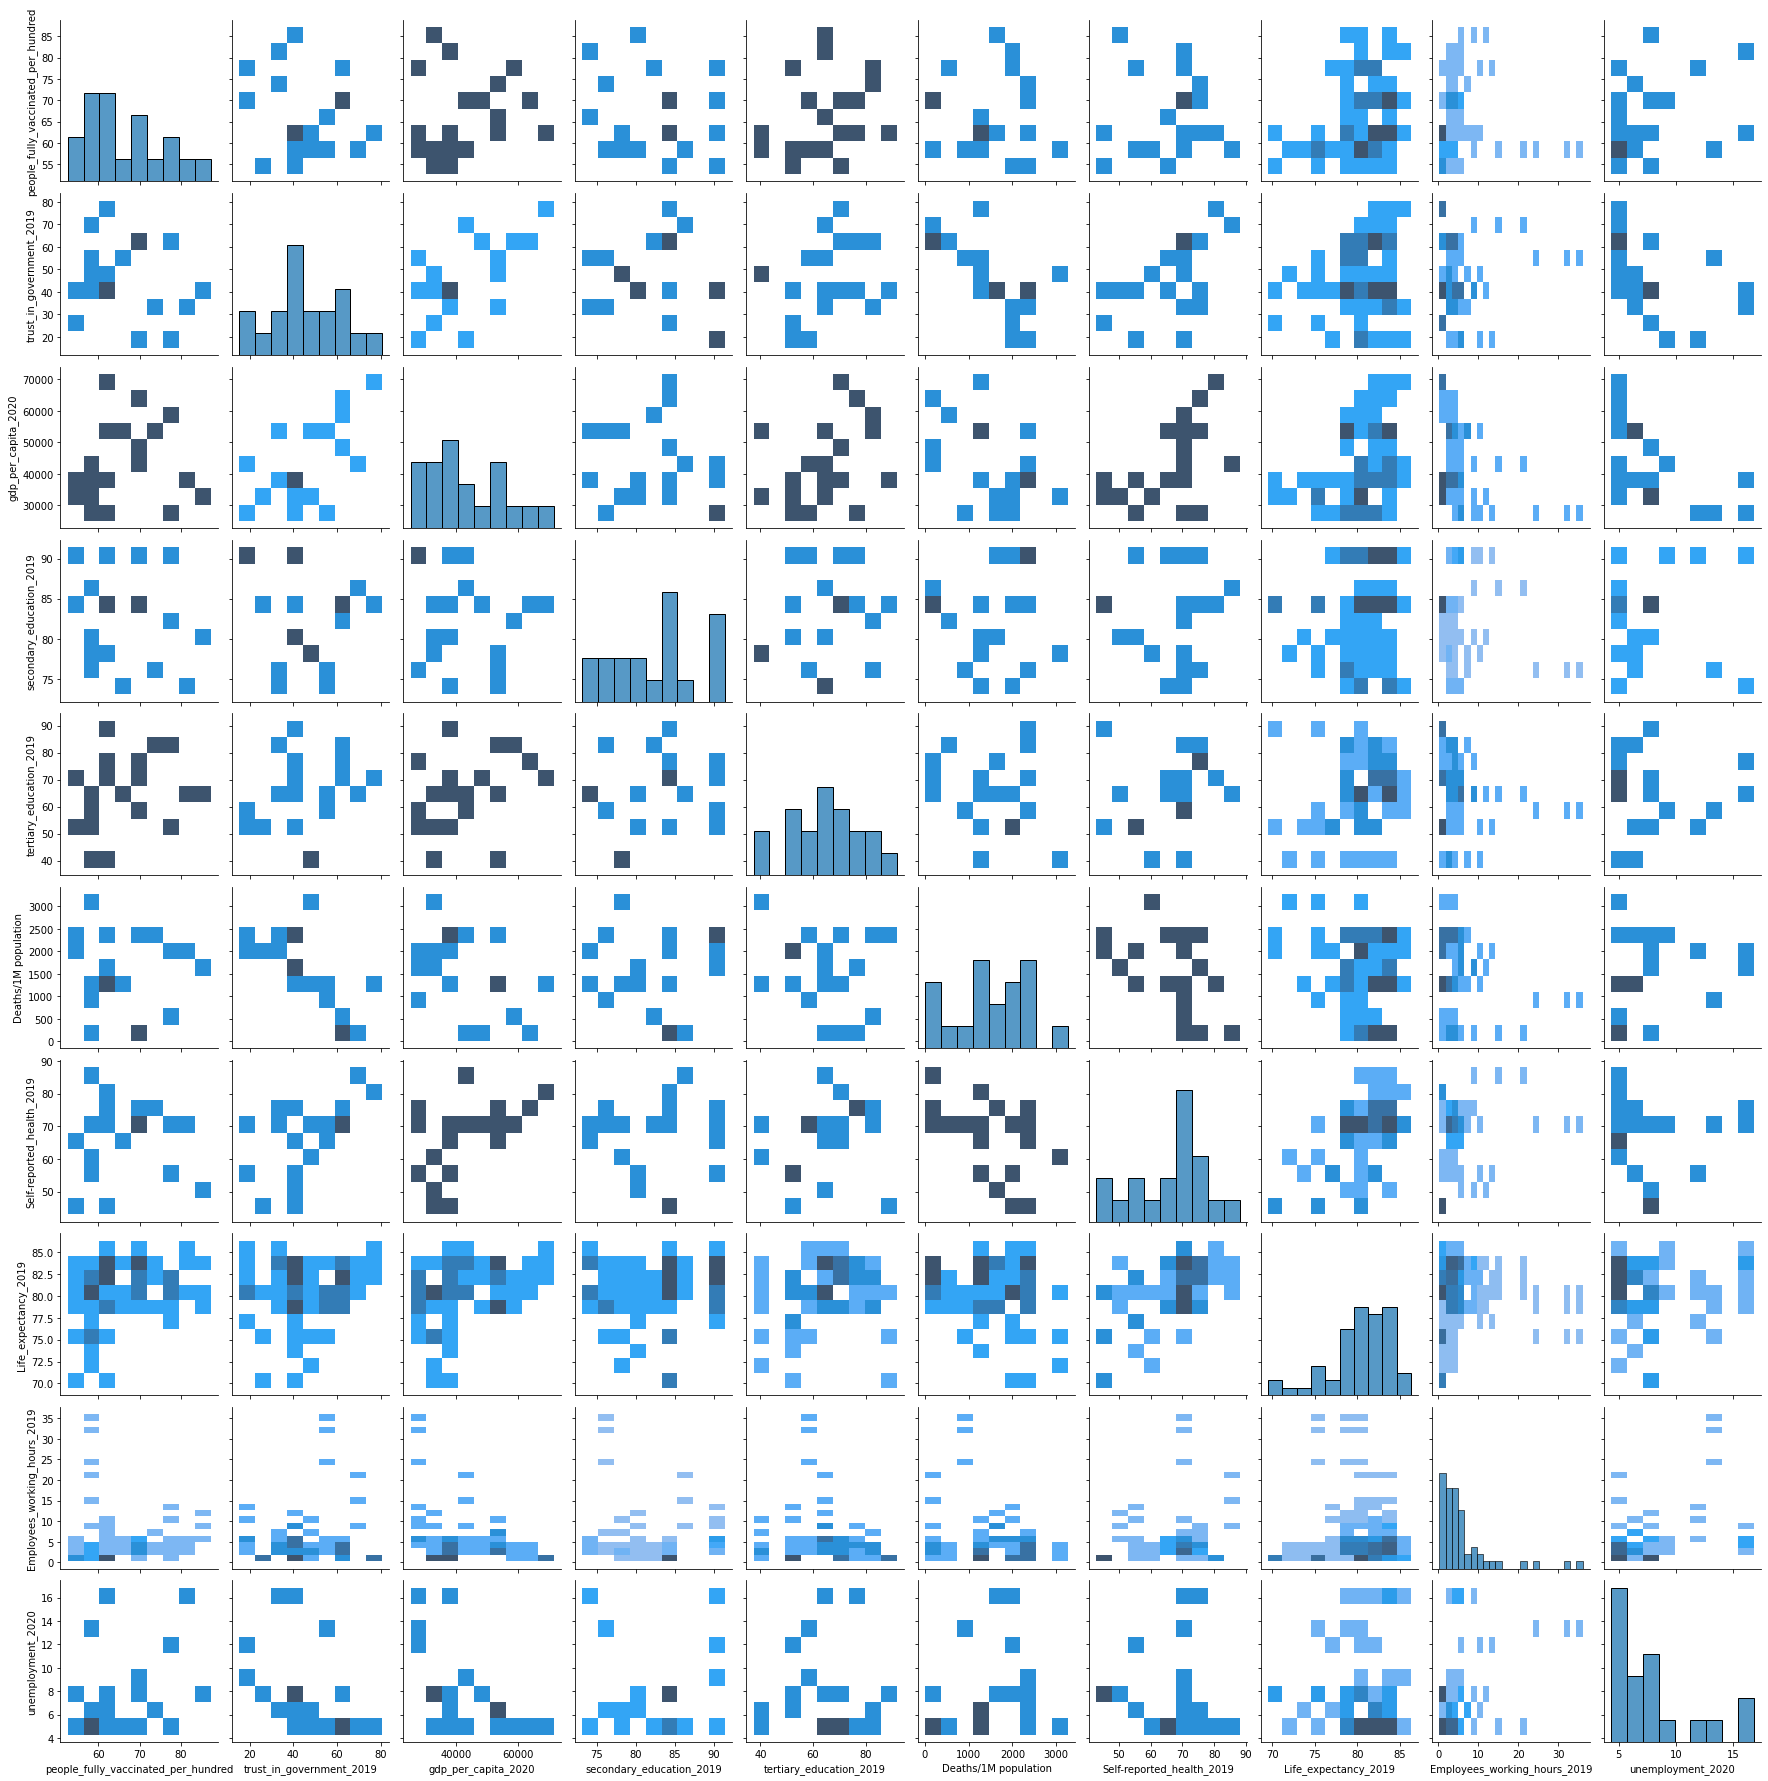

In [39]:
sns.pairplot(data, kind="hist")

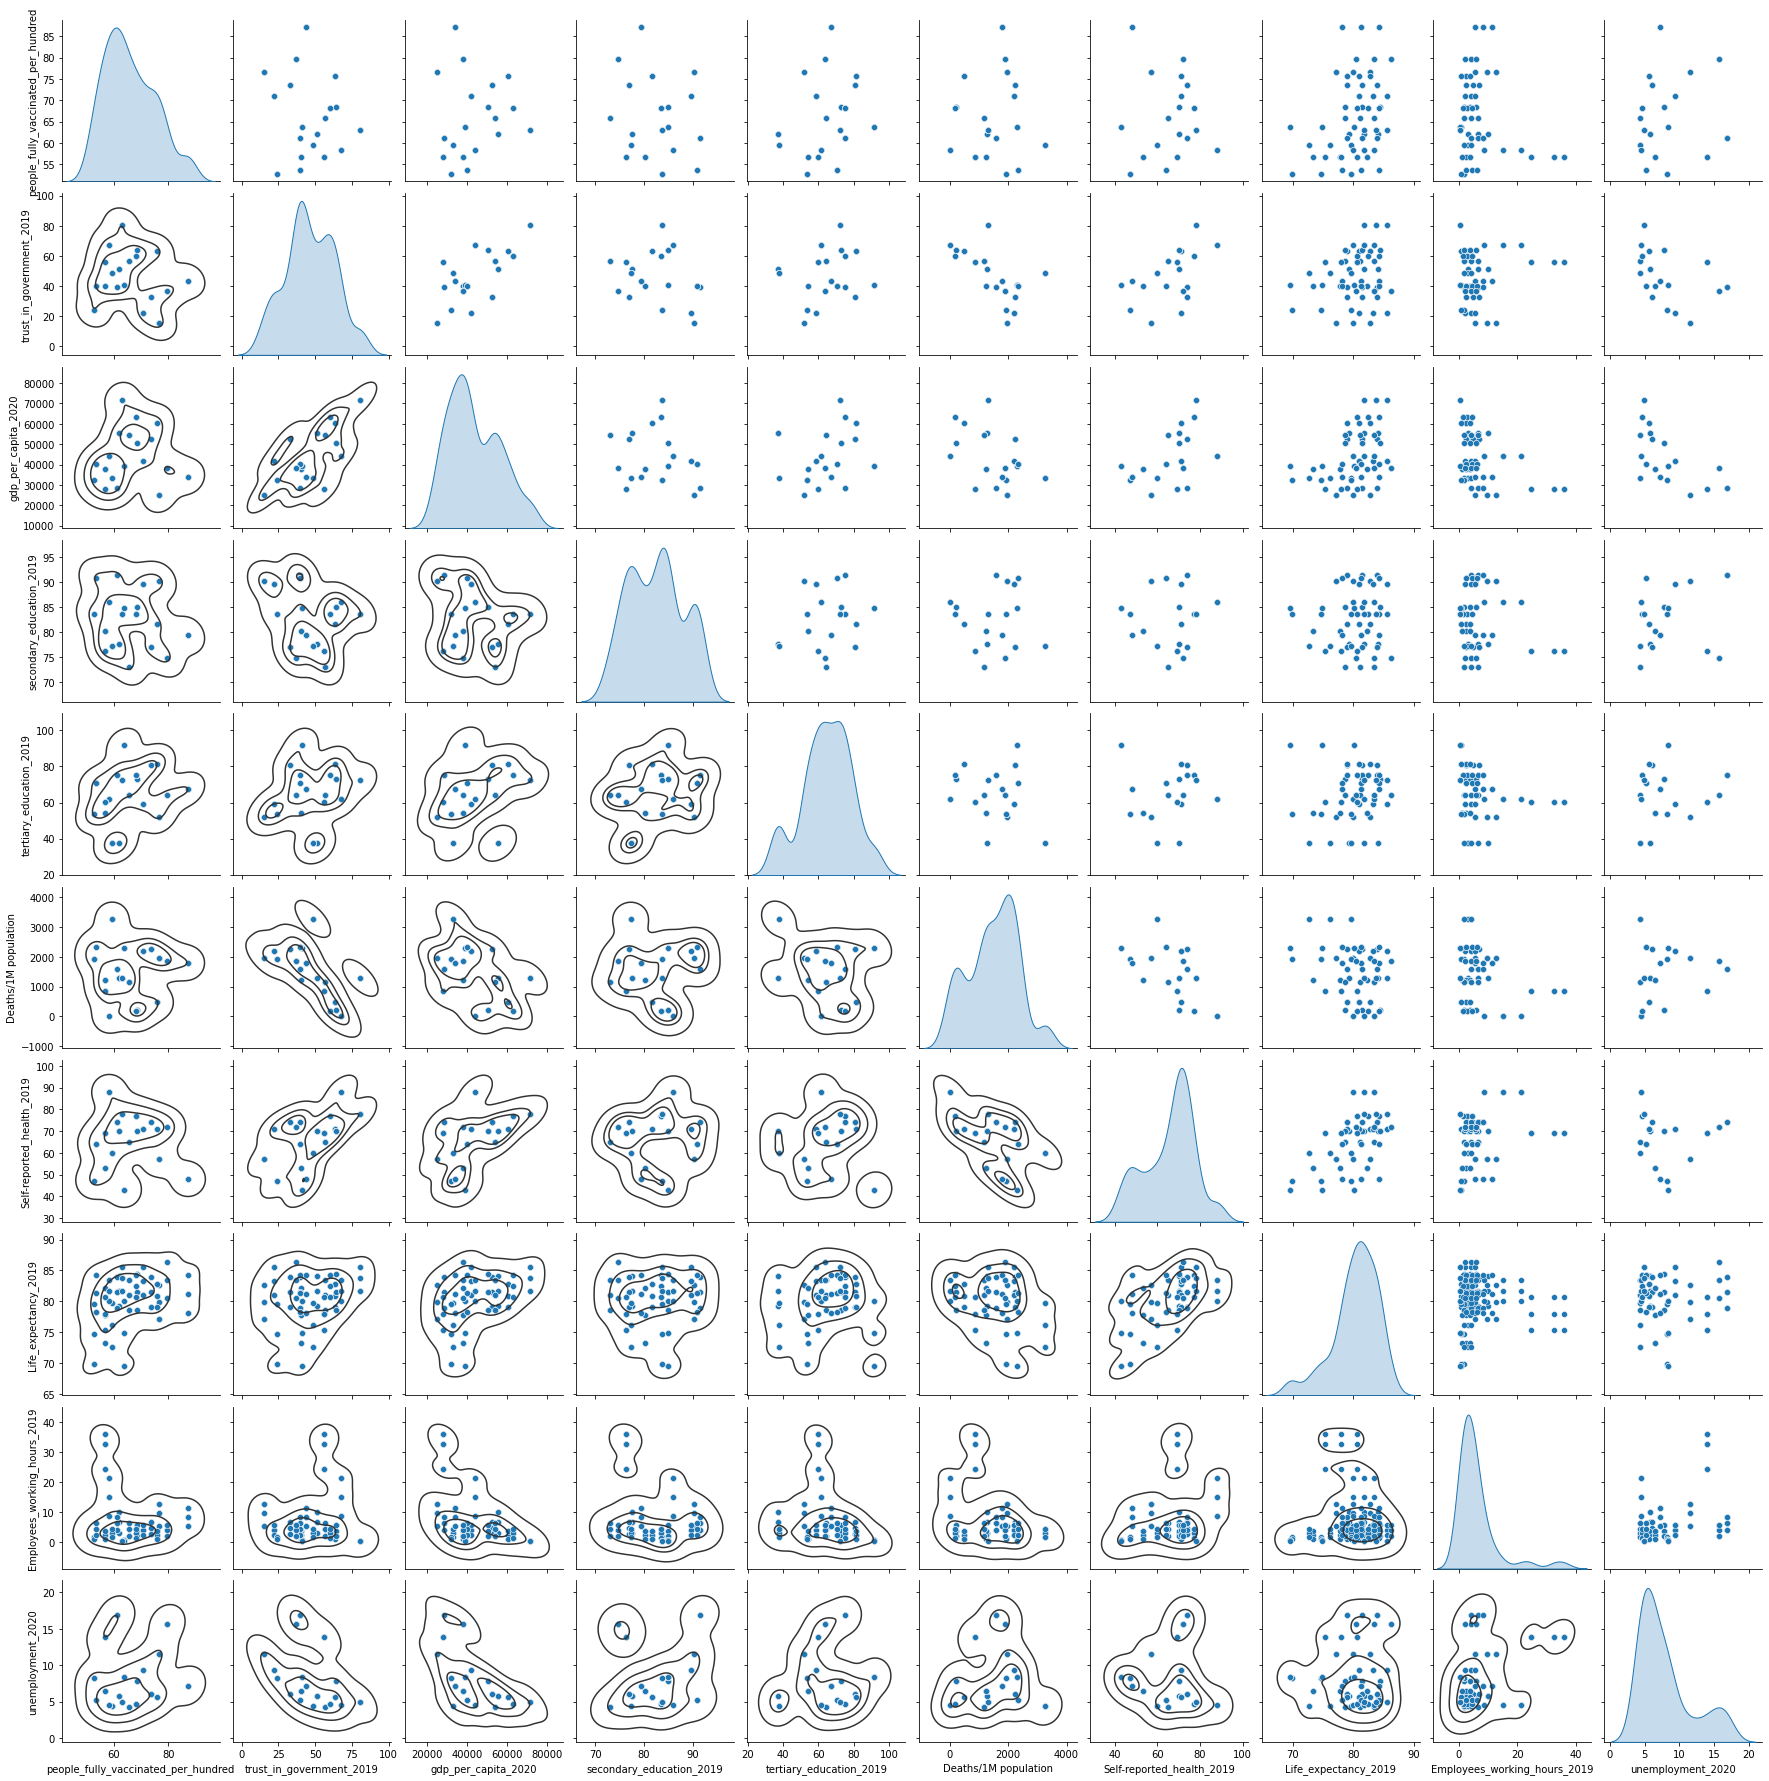

In [43]:
g = sns.pairplot(data, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")